<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado_ejemplo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [2]:
#!pip uninstall nlptweet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
#import re
import timeit
import string
# Nuestro paquete
import nlp


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweety

# Carga y limpieza de datos

In [5]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving smaller_sample_100000.csv to smaller_sample_100000.csv


In [7]:
training =  pd.read_csv('smaller_sample_100000.csv',
                 encoding='latin-1')

In [6]:
test = pd.read_csv('testdata_manual_2009_06_14.csv', names=col_names)

In [10]:
print(training.shape)
print(test.shape)

(100000, 6)
(498, 6)


In [11]:
training.head(50)

,target,ids,date,flag,user,text
0,0,2214844405,Wed Jun 17 17:18:46 PDT 2009,NO_QUERY,thechillmaster,going to bed now...feeling sad
1,0,2176921086,Mon Jun 15 05:03:41 PDT 2009,NO_QUERY,Liebe93,"Ugh, I feel another headache coming on... *goe..."
2,0,2296949656,Tue Jun 23 09:50:27 PDT 2009,NO_QUERY,brandielachelle,"job applications DAY 2 ,"
3,4,1980618237,Sun May 31 07:14:02 PDT 2009,NO_QUERY,triiishh,3 hours of ToA. Isn't that lovely?
4,4,1470156375,Tue Apr 07 08:30:57 PDT 2009,NO_QUERY,sessisen,@malinpet &quot;Go:Audio = LOVE!&quot; Indeed!...
5,4,2066518886,Sun Jun 07 10:40:22 PDT 2009,NO_QUERY,phunwears,brand new purple fairy pants http://phunwears...
6,4,1960391146,Fri May 29 07:53:24 PDT 2009,NO_QUERY,serwaygirl,@WorldinMotion i was sharing!
7,0,2204076111,Wed Jun 17 01:15:38 PDT 2009,NO_QUERY,Lucieyoung,Neeeddds a vacationnnnn right about now!!! xoxox
8,0,1556421697,Sat Apr 18 22:46:28 PDT 2009,NO_QUERY,msredmond,People who assume I drive and have my own way ...
9,4,2065265926,Sun Jun 07 08:14:22 PDT 2009,NO_QUERY,shaju,Weekend pass by........ new week to start off


In [9]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,4,1470156375,Tue Apr 07 08:30:57 PDT 2009,NO_QUERY,sessisen,@malinpet &quot;Go:Audio = LOVE!&quot; Indeed!...
8,0,1556421697,Sat Apr 18 22:46:28 PDT 2009,NO_QUERY,msredmond,People who assume I drive and have my own way ...
27,0,2302191492,Tue Jun 23 16:27:54 PDT 2009,NO_QUERY,CelloBard,Too sick. Scaling writing goal back. New goa...
41,4,1692059006,Sun May 03 19:11:21 PDT 2009,NO_QUERY,spnheroesbaker,@speccygeekgrrl Very true. My mom's been tryin...
44,0,2048707629,Fri Jun 05 15:38:32 PDT 2009,NO_QUERY,damog,"@garyvee Iced coffee, unsweetened."
35,0,2262604412,Sat Jun 20 22:50:57 PDT 2009,NO_QUERY,HillaryHaynes92,is by herself for the second night in a roww.
48,4,2063711158,Sun Jun 07 03:46:33 PDT 2009,NO_QUERY,Dear__Gravity,80 followersss shhhhh.
155,4,1556610439,Sat Apr 18 23:33:00 PDT 2009,NO_QUERY,nigs,@poohsuke It's good to know you have family wi...


In [12]:
import re as re
def reemplazar_usuarios(phrase):
    """
    :param phrase:
    :return:
    """
    return re.sub("@[\S]+", "", phrase)

def reemplazar_urls(phrase):
    """
    :param phrase:
    :return:
    """
    return re.sub("((www\.[\S]+)|(https?://[\S]+))", "", phrase)

In [13]:
# primera parte limpieza
from nlp.preprocessing import convierte_a_minusculas, quitar_hashtag #reemplazar_urls, reemplazar_usuarios, 
# minusculas
training = convierte_a_minusculas(training)
test = convierte_a_minusculas(test)
# url
training['text'] = training['text'].map(lambda s: reemplazar_urls(s))
test['text'] = test['text'].map(lambda s: reemplazar_urls(s))
# user_mention
training['text'] = training['text'].map(lambda s: reemplazar_usuarios(s))
test['text'] = test['text'].map(lambda s: reemplazar_usuarios(s))
# hashtags
training['text'] = training['text'].map(lambda s: quitar_hashtag(s))
test['text'] = test['text'].map(lambda s: quitar_hashtag(s))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,4,1470156375,tue apr 07 08:30:57 pdt 2009,no_query,sessisen,&quot;go:audio = love!&quot; indeed! awesome...
8,0,1556421697,sat apr 18 22:46:28 pdt 2009,no_query,msredmond,people who assume i drive and have my own way ...
27,0,2302191492,tue jun 23 16:27:54 pdt 2009,no_query,cellobard,too sick. scaling writing goal back. new goa...
41,4,1692059006,sun may 03 19:11:21 pdt 2009,no_query,spnheroesbaker,"very true. my mom's been trying to quit, but ..."
44,0,2048707629,fri jun 05 15:38:32 pdt 2009,no_query,damog,"iced coffee, unsweetened."
35,0,2262604412,sat jun 20 22:50:57 pdt 2009,no_query,hillaryhaynes92,is by herself for the second night in a roww.
48,4,2063711158,sun jun 07 03:46:33 pdt 2009,no_query,dear__gravity,80 followersss shhhhh.
155,4,1556610439,sat apr 18 23:33:00 pdt 2009,no_query,nigs,it's good to know you have family with you in...


In [15]:
# segunda parte limpieza
from nlp.preprocessing import quitar_RT, quitar_caracteres_especiales, quitar_letras_repetidas
# retweets
training['text'] = training['text'].map(lambda s: quitar_RT(s))
test['text'] = test['text'].map(lambda s: quitar_RT(s))
# caracteres especiales
training['text'] = training['text'].map(lambda s: quitar_caracteres_especiales(s))
test['text'] = test['text'].map(lambda s: quitar_caracteres_especiales(s))
# letras repetidas
training['text'] = training['text'].map(lambda s: quitar_letras_repetidas(s))
test['text'] = test['text'].map(lambda s: quitar_letras_repetidas(s))

In [16]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,4,1470156375,tue apr 07 08:30:57 pdt 2009,no_query,sessisen,&quotgoaudio = love&quot indeed awesomeness a...
8,0,1556421697,sat apr 18 22:46:28 pdt 2009,no_query,msredmond,people who assume i drive and have my own way ...
27,0,2302191492,tue jun 23 16:27:54 pdt 2009,no_query,cellobard,too sick scaling writing goal back new goals 1...
41,4,1692059006,sun may 03 19:11:21 pdt 2009,no_query,spnheroesbaker,very true my mom's been trying to quit but sh...
44,0,2048707629,fri jun 05 15:38:32 pdt 2009,no_query,damog,iced coffee unsweetened
35,0,2262604412,sat jun 20 22:50:57 pdt 2009,no_query,hillaryhaynes92,is by herself for the second night in a roww
48,4,2063711158,sun jun 07 03:46:33 pdt 2009,no_query,dear__gravity,80 followerss shh
155,4,1556610439,sat apr 18 23:33:00 pdt 2009,no_query,nigs,it's good to know you have family with you in...


In [17]:
# tercera parte limpieza
from nlp.preprocessing import quitar_nonascii, separar_abreviaciones, remove_stopwords, oracion_raiz
#nonascii
training['text'] = training['text'].map(lambda s: quitar_nonascii(s))
test['text'] = test['text'].map(lambda s: quitar_nonascii(s))
# abreviaciones
training['text'] = training['text'].map(lambda s: separar_abreviaciones(s))
test['text'] = test['text'].map(lambda s: separar_abreviaciones(s))
# stop words
training['text'] = training['text'].map(lambda s: remove_stopwords(s))
test['atext'] = test['text'].map(lambda s: remove_stopwords(s))
# raiz
training['text'] = training['text'].map(lambda s: oracion_raiz(s))
test['atext'] = test['text'].map(lambda s: oracion_raiz(s))

In [18]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,4,1470156375,tue apr 07 08:30:57 pdt 2009,no_query,sessisen,& quotgoaudio = love & quot inde awesom best
8,0,1556421697,sat apr 18 22:46:28 pdt 2009,no_query,msredmond,peopl assum drive way home frequent mistaken
27,0,2302191492,tue jun 23 16:27:54 pdt 2009,no_query,cellobard,sick scale write goal back new goal 1 chemo pu...
41,4,1692059006,sun may 03 19:11:21 pdt 2009,no_query,spnheroesbaker,true mom tri quit bought pack today *give those*
44,0,2048707629,fri jun 05 15:38:32 pdt 2009,no_query,damog,ice coffe unsweeten
35,0,2262604412,sat jun 20 22:50:57 pdt 2009,no_query,hillaryhaynes92,second night roww
48,4,2063711158,sun jun 07 03:46:33 pdt 2009,no_query,dear__gravity,80 followerss shh
155,4,1556610439,sat apr 18 23:33:00 pdt 2009,no_query,nigs,good know famili honolulu start cool today 3c ...


In [19]:
training.text

0                                      go bed nowfeel sad 
1        ugh feel anoth headach come *goe grab ibuprofe...
2                                        job applic day 2 
3                                         3 hour toa love 
4            & quotgoaudio = love & quot inde awesom best 
                               ...                        
99995        thx follow jenni add seminar twitter jobseek 
99996    listen new bootleg make super excit lifehous n...
99997                              hey money miley ticket 
99998                                glad hear oke *hugs* 
99999                           fantast love pimm o'clock 
Name: text, Length: 100000, dtype: object

# Entrenamos un Tokenizer

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [21]:
# Entrena un Tokenizer. Consiste en:
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las N palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)
data_set_1 = training
data_set_1.shape
data_set_1.text

0                                      go bed nowfeel sad 
1        ugh feel anoth headach come *goe grab ibuprofe...
2                                        job applic day 2 
3                                         3 hour toa love 
4            & quotgoaudio = love & quot inde awesom best 
                               ...                        
99995        thx follow jenni add seminar twitter jobseek 
99996    listen new bootleg make super excit lifehous n...
99997                              hey money miley ticket 
99998                                glad hear oke *hugs* 
99999                           fantast love pimm o'clock 
Name: text, Length: 100000, dtype: object

In [26]:
max_words = 1000
max_len = 21

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_set_1.text)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 51042
[('go', 1), ('get', 2), ('day', 3), ('good', 4), ('work', 5), ('like', 6), ('love', 7), ('got', 8), ('today', 9), ('time', 10)]


In [27]:
#sorted(tokenizer.word_counts.values())[:10]
#Tokenizer?

In [28]:
# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(data_set_1.text)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Tweet más pequeño", np.array(lengths).min(), "words.")
print("Tweet más grande", np.array(lengths).max(), "words.")
print(f"Longitud promedio: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

for seq in train_sequences[:10]:
  print(seq)

Tweet más pequeño 0 words.
Tweet más grande 21 words.
Longitud promedio: 5.03 +- 3.11 words.


[1, 73, 52]
[223, 19, 129, 311, 36, 414, 614, 346]
[231, 3, 38]
[114, 79, 7]
[7, 39, 838, 87, 102]
[32]
[497]
[58]
[80, 274, 65, 37]
[83, 404, 32, 53, 75]


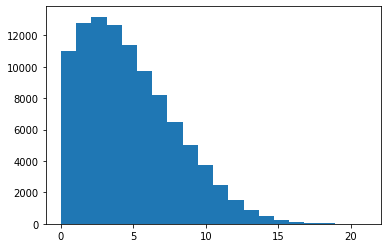

In [29]:
plt.hist(lengths,20)
plt.show()

In [30]:
sequences = tokenizer.texts_to_sequences(data_set_1.text)
tweets = pad_sequences(sequences, maxlen=max_len, padding='post')
print(tweets)

[[  1  73  52 ...   0   0   0]
 [223  19 129 ...   0   0   0]
 [231   3  38 ...   0   0   0]
 ...
 [ 85 309 685 ...   0   0   0]
 [203 180   0 ...   0   0   0]
 [859   7   0 ...   0   0   0]]


In [31]:
tweets.shape

(100000, 21)

In [32]:
data_set_1.target.shape

(100000,)

## Separamos en train, test

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data_set_1.target.values, test_size=0.3, random_state=23042021)

In [37]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (70000, 21)
y_train (70000,)
X_test (30000, 21)
y_test (30000,)


In [35]:
y_train = np.where(y_train==4,1,y_train)
y_test = np.where(y_test==4,1,y_test)

In [36]:
y_train
y_test

array([0, 1, 1, ..., 0, 1, 0])

# Creamos el modelo

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1

In [39]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=max_len, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=82, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 82)                5330      
_________________________________________________________________
dropout_1 (Dropout)          (None, 82)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 83        
Total params: 102,437
Trainable params: 102,437
Non-trainable params: 0
__________________________________________________

In [40]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [41]:
#%%timeit

# Train it
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
3500/3500 [==============================] - 39s 10ms/step - loss: 0.6117 - binary_accuracy: 0.6405 - accuracy: 0.6405 - val_loss: 0.5232 - val_binary_accuracy: 0.7404 - val_accuracy: 0.7404
Epoch 2/10
3500/3500 [==============================] - 35s 10ms/step - loss: 0.5251 - binary_accuracy: 0.7406 - accuracy: 0.7406 - val_loss: 0.5321 - val_binary_accuracy: 0.7254 - val_accuracy: 0.7254
Epoch 3/10
3500/3500 [==============================] - 35s 10ms/step - loss: 0.5087 - binary_accuracy: 0.7493 - accuracy: 0.7493 - val_loss: 0.5218 - val_binary_accuracy: 0.7406 - val_accuracy: 0.7406
Epoch 4/10
3500/3500 [==============================] - 36s 10ms/step - loss: 0.4981 - binary_accuracy: 0.7578 - accuracy: 0.7578 - val_loss: 0.5188 - val_binary_accuracy: 0.7424 - val_accuracy: 0.7424
Epoch 5/10
3500/3500 [==============================] - 36s 10ms/step - loss: 0.4894 - binary_accuracy: 0.7622 - accuracy: 0.7622 - val_loss: 0.5212 - val_binary_accuracy: 0.7424 - val_accurac

In [42]:
history

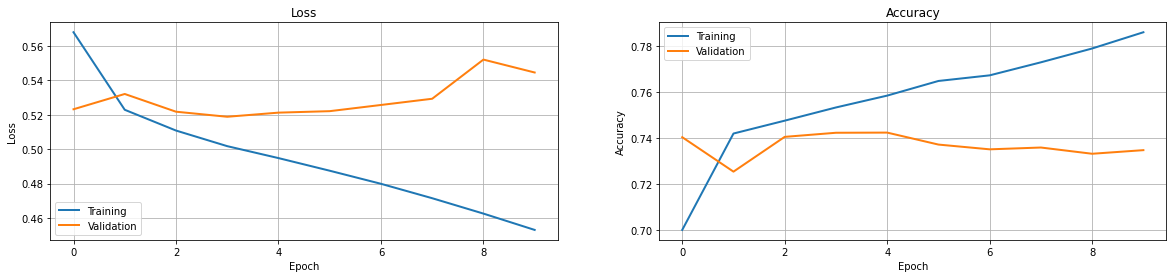

In [43]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()